In [30]:
import pandas as pd
import time
start_time = time.time()

columns = ['patientunitstayid', 'labname', 'labresult', 'labresultoffset', 'age', 'gender', \
           'ethnicity', 'patienthealthsystemstayid', 'hospitaladmitoffset', 'unitdischargeoffset']

neg_lab = pd.DataFrame()

chunksize = 10 ** 6
for chunk in pd.read_csv('../data/intermediate/negative_lab_data.csv', header=None, chunksize=chunksize):
    chunk.columns=columns
    chunk = pd.pivot_table(chunk, values=['labresult'], \
               index=['patientunitstayid', 'labresultoffset', 'age', 'gender', 'ethnicity', \
                      'patienthealthsystemstayid', 'hospitaladmitoffset', 'unitdischargeoffset'], \
               columns=['labname'], aggfunc='first')
    chunk.columns = chunk.columns.droplevel() # reshape column level
    chunk.columns = chunk.columns.tolist()
    neg_lab = pd.concat([neg_lab, chunk], axis=0)
    print("Processed 1 chunk", time.time() - start_time)
    start_time = time.time()

Processed 1 chunk 2.5950870513916016
Processed 1 chunk 2.8986728191375732
Processed 1 chunk 2.823415994644165
Processed 1 chunk 2.646502733230591
Processed 1 chunk 2.8588480949401855
Processed 1 chunk 0.9499151706695557


In [31]:
neg_lab['positive_window'] = 0
null_rows = neg_lab[['BUN', 'bicarbonate', 'calcium', 'chloride', 'creatinine', 'glucose', 'potassium',\
                     'sodium']].isna().sum(axis=0)
null_rows

BUN            140625
bicarbonate    179228
calcium        163744
chloride       133436
creatinine     135857
glucose        116993
potassium       33732
sodium          81484
dtype: int64

In [32]:
neg_lab.dropna(inplace=True)
print(len(neg_lab))

557230


In [33]:
neg_lab.reset_index(inplace=True)
neg_lab.sort_values(by=['patientunitstayid', 'labresultoffset'], ascending=True, inplace=True)

In [34]:
import numpy as np

indices = neg_lab['patientunitstayid'].unique()
index_rand = np.random.choice(indices, size=25000, replace=False)
index_rand.shape

(25000,)

In [35]:
index_rand

array([2784208, 2043186, 3224646, ..., 3026533, 2758157, 2285484])

In [36]:
neg_lab_rand = neg_lab[neg_lab['patientunitstayid'].isin(index_rand)]
len(neg_lab_rand)

118588

In [13]:
import sys, os
sys.path.insert(0, os.path.abspath('../src/'))
import lab_wrangling

In [37]:
start_time = time.time()
columns = ['BUN', 'bicarbonate', 'calcium', 'chloride', 'creatinine', 'glucose','potassium', 'sodium']
funcs = ['min', 'mean', 'max', 'var']
df = neg_lab_rand
neg_lab_rand = lab_wrangling.calc_stats_windows(df, columns, funcs, 'labresultoffset')
print(time.time() - start_time)

/Users/zhannahakhverdyan/Insight/eICU_AKIlert/src/lab_wrangling.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[timecolumn] = pd.to_timedelta(df[timecolumn], unit='minute')


647.8676857948303


In [39]:
print(len(neg_lab_rand))
neg_lab_rand.dropna(inplace=True)
print(len(neg_lab_rand))

118588
89332


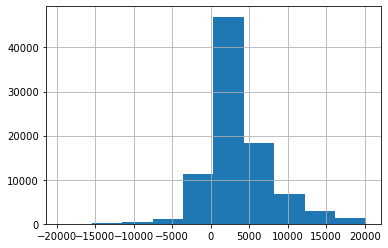

In [42]:
(neg_lab_rand.reset_index()['labresultoffset']/pd.Timedelta('1 minute')).hist()

In [43]:
neg_lab_rand.to_csv('../data/final/negative_class_rand_lab_wrangled.csv')

In [44]:
start_time = time.time()
columns = ['BUN', 'bicarbonate', 'calcium', 'chloride', 'creatinine', 'glucose','potassium', 'sodium']
funcs = ['min', 'mean', 'max', 'var']
df = neg_lab
neg_lab = lab_wrangling.calc_stats_windows(df, columns, funcs, 'labresultoffset')
print(time.time() - start_time)

2587.8352460861206


In [45]:
print(len(neg_lab))
neg_lab.dropna(inplace=True)
print(len(neg_lab))

557230
420552


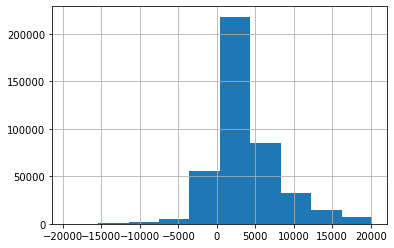

In [47]:
(neg_lab.reset_index()['labresultoffset']/pd.Timedelta('1 minute')).hist()

In [48]:
neg_lab_rand.to_csv('../data/final/negative_class_lab_wrangled.csv')